In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

In [5]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        elif predictor_type == 'MVI' or predictor_type == 'savgol_raw':
            date_columns = []
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

def interpolate_columns(ds, numdays, varname):
    for day in range(numdays):
        upper = int((day // 4)*4 + 4)
        lower = int((day // 4)*4)
        coeff = (day % 4)/4
        #print(lower, upper, coeff)
        #print(ds.loc[:, f'{varname} interpolated at day {upper}'].mean(), ds.loc[:, f'{varname} interpolated at day {lower}'].mean())
        ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*ds.loc[:, f'{varname} interpolated at day {lower}']
    return ds

In [6]:
ds_reanalysis_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_Africa_t2m_WC_SOS.csv')
ds_reanalysis_SSA = ds_reanalysis_SSA.drop('Unnamed: 0', axis = 1).rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_SSA['year'] = ds_reanalysis_SSA['year'].astype(int)
ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_WC_SOS.csv')
ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['WC SOS date'] = pd.to_datetime(ds_inputs_SSA['WC SOS date'])
date_columns = ['mingrad', 'maxgrad', 
                'minday', 'maxday', 
                'first 50 percentile', 'last 50 percentile', 
                'first 90 percentile', 'last 90 percentile', 
                'observed time to beginning of flowering']
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
ds_inputs_SSA = interpolate_columns(ds_inputs_SSA, 195, 'NDVI')
#for column in date_columns:
#    ds_inputs_SSA[column] = pd.to_datetime(ds_inputs_SSA[column])
#    ds_inputs_SSA[column] = ds_inputs_SSA[column] - ds_inputs_SSA['WC SOS date']
#    ds_inputs_SSA[column] = ds_inputs_SSA[column].dt.days 
                

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3996\3988289945.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*ds.loc[:, f'{varname} interpolated at day {lower}']
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3996\3988289945.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*

In [7]:
ds_reanalysis_DE = read_reanalysis()
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 0]
ds_inputs_DE = interpolate_columns(ds_inputs_DE, 195, 'NDVI')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3996\3988289945.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3996\3988289945.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day

In [8]:
#ds_inputs_DE[['NDVI interpolated at day 100', 'NDVI interpolated at day 101', 'NDVI interpolated at day 102', 'NDVI interpolated at day 103', 'NDVI interpolated at day 104']]

In [9]:
#ds_inputs_SSA['observed time to beginning of flowering']#[['Day of start', 'WC SOS date']]

In [10]:
#pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days.min()

In [11]:
NDVI_series = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {12 + n}' for n in range(183)]].values)
temp_series = torch.Tensor(ds_inputs_DE[[f't2m at day {n}' for n in range(183)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)
NDVI_labels = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].values)

In [97]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(195)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n}' for n in range(195)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)
NDVI_labels = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].values)

In [123]:
class phen_CNN_1d(nn.Module):
    #def __init__(self):
    #    super().__init__()
        

    #def forward(self, xb):
    #    return self.lin(xb)
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 3, kernel_size=9, padding=4)
        self.conv2 = nn.Conv1d(3, 3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(3, 1, kernel_size=3, padding=1)
        self.lin = nn.Linear(40, 1)
        self.pool = torch.nn.AvgPool1d(kernel_size=183, padding = 0)
    
    def forward(self, xb):
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv1(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        #xb = torch.nn.functional.leaky_relu(self.conv2(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv3(xb), negative_slope=0.001)
        #xb = torch.nn.functional.relu(self.conv3(xb))
        #print(xb[0, :])
        xb = self.pool(xb)
        #print(xb[0, :, :])
        #print(xb[0, :])
        return xb.view(-1, xb.size(1))

def get_model():
    model = phen_CNN_1d()
    return model, optim.SGD(model.parameters(), lr=lr)

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = torch.sqrt(loss_func(model(xb), yb))

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 40)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def plot_train_val_loss(num_epochs, train_losses, val_losses, best_epoch):

    epochs = range(1, num_epochs + 1)
    # Plot Losses
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses, label='Val Loss')
    ax.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
    fig.suptitle('Loss vs Epoch')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ymax = (np.array(val_losses)[:20].max())*1.05
    ax.set_ylim([0, ymax])
    plt.legend()

    # Show the plots
    plt.tight_layout()

def dl_variance(dl):
    running_var = 0
    running_len = 0
    for xb, yb in dl:
        running_var += torch.var(yb)*(len(yb) - 1)
        running_len += len(yb)
    return running_var/(running_len - 1)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 10000
    best_epoch = 0
    
    train_var = dl_variance(train_dl)
    val_var = dl_variance(valid_dl)

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()
        running_var = 0
        running_var_val = 0

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt)
            #print(batch_loss**2
            running_loss += (batch_loss**2)*batch_len
            running_samples += batch_len
            
            #print(batch_loss, batch_len, running_samples)
        train_loss = np.sqrt(running_loss/running_samples)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
        val_loss = np.sqrt(np.sum(np.multiply(np.power(losses, 2), nums)) / np.sum(nums))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        #if val_loss < best_loss:
        #    best_loss = val_loss
        #    best_epoch = epoch + 1
        #    torch.save(model.state_dict(), 'saved_models/best_test.pth')

        # Save the model at the last epoch
        #if epoch == epochs - 1:
        #    torch.save(model.state_dict(), 'saved_models/last_test.pth')

        if epoch % 50 == 0:
            train_r2 = 1 - ((val_loss**2)/val_var)
            val_r2 = 1 - ((train_loss**2)/train_var)
            print(epoch, val_loss, train_loss)
            print(f'R2 on train set: {train_r2}\nR2 on test set: {val_r2}')
    plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

def preprocess(x, y, channels = 1):
    if channels == 1:
        return x[:, None, :], y.view(-1, 1)
    else:
        return x, y.view(-1, 1)

def train_test_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(0.8 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [129]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series, NDVI_labels, bs = bs, n_channels = n_channels)

In [134]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(temp_series, NDVI_labels, bs = bs, n_channels = n_channels)

In [131]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series, NDVI_labels, bs = bs, n_channels = n_channels)

0 5214.3896484375 2799.8731362427325
R2 on train set: -289325.5625
R2 on test set: -76768.6328125
50 12.977822303771973 13.568335767245996
R2 on train set: -0.7921937704086304
R2 on test set: -0.8028762340545654
100 12.55649185180664 13.14493849430596
R2 on train set: -0.6777139902114868
R2 on test set: -0.692115068435669
150 12.153369903564453 12.737744598986993
R2 on train set: -0.5717184543609619
R2 on test set: -0.588904619216919
200 11.76553726196289 12.343233858919783
R2 on train set: -0.4730072021484375
R2 on test set: -0.4920063018798828
250 11.385428428649902 11.955728335051491
R2 on train set: -0.3793677091598511
R2 on test set: -0.3997962474822998


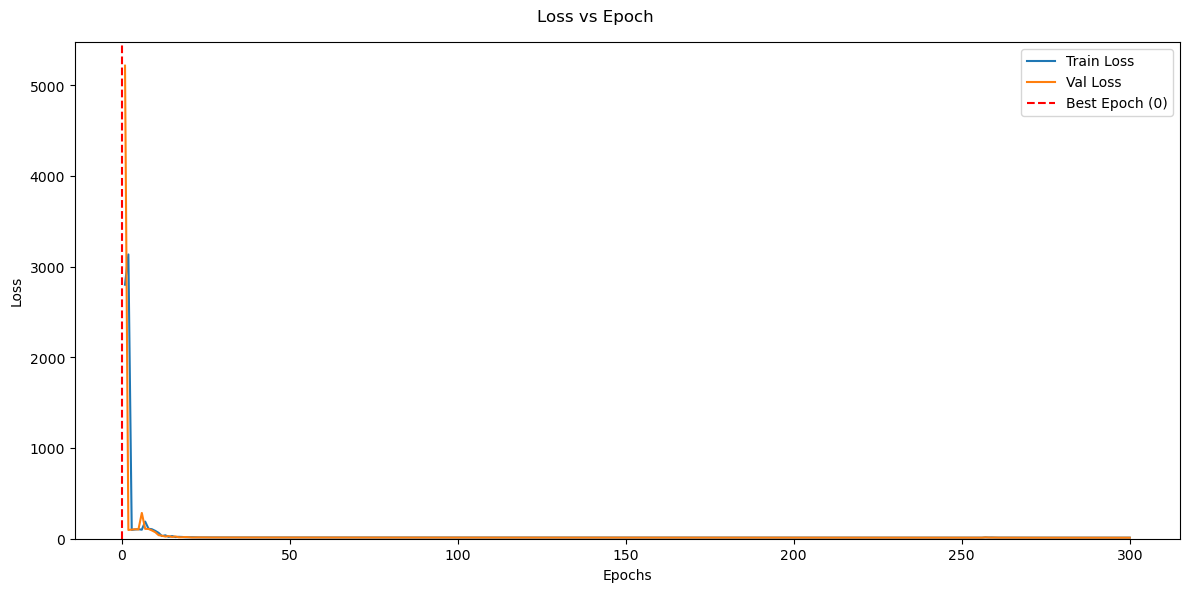

In [135]:
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 3, kernel_size=9, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 300
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl)

In [56]:
for dl in val_dl:
    print(dl[1].shape)

torch.Size([344, 1])


0 9.722724914550781 9.695372348689386
R2 on train set: 0.12865447998046875
R2 on test set: 0.045926570892333984
50 9.720691680908203 9.678795462363116
R2 on train set: 0.1290189027786255
R2 on test set: 0.04918622970581055
100 9.719098091125488 9.662414215418346
R2 on train set: 0.1293044090270996
R2 on test set: 0.052401959896087646
150 9.717077255249023 9.646576356232995
R2 on train set: 0.12966644763946533
R2 on test set: 0.05550593137741089
200 9.715126037597656 9.631246187371971
R2 on train set: 0.13001596927642822
R2 on test set: 0.058505475521087646
250 9.714205741882324 9.616819761645118
R2 on train set: 0.13018077611923218
R2 on test set: 0.06132382154464722
300 9.713150978088379 9.603506679575657
R2 on train set: 0.1303696632385254
R2 on test set: 0.06392097473144531
350 9.712679862976074 9.590703341569625
R2 on train set: 0.13045400381088257
R2 on test set: 0.06641525030136108
400 9.710673332214355 9.577816897124755
R2 on train set: 0.13081324100494385
R2 on test set: 0.0689

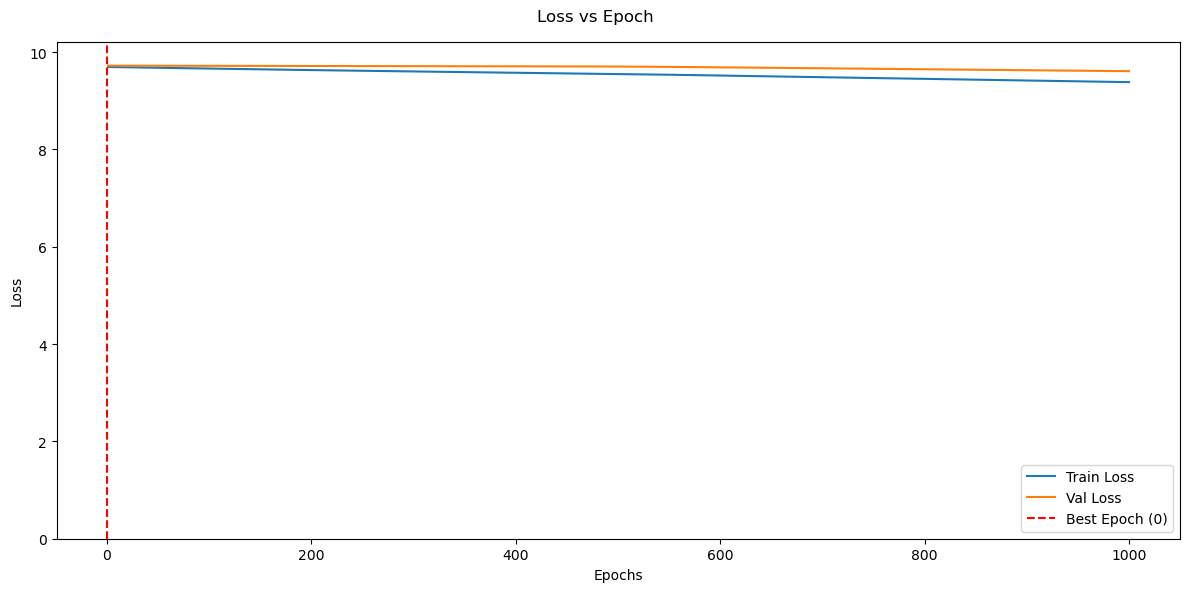

In [49]:
model, opt = get_model()
print(loss_func(model(xb), yb))

In [ ]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n*4}' for n in range(25)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n*4}' for n in range(25)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)

In [58]:
in_channels = 2
out_channels = 4
Kernel_size = 4
c = torch.nn.Conv1d(in_channels, out_channels, Kernel_size)

In [61]:
temp_NDVI_series.shape

torch.Size([240, 2, 25])

In [60]:
c(temp_NDVI_series).shape

torch.Size([240, 4, 22])

In [33]:
ds_inputs_DE.dropna(how='any')[['Day of start', 'WC SOS date']]

# Note to self: start NDVI a bit along

,Day of start,WC SOS date
19,2018-04-03,2018-04-15
20,2019-04-03,2019-04-15
21,2020-04-02,2020-04-14
22,2021-04-03,2021-04-15
23,2022-04-03,2022-04-15
...,...,...
21500,2021-04-03,2021-04-15
21501,2022-04-03,2022-04-15
21519,2017-04-03,2017-04-17
21586,2018-04-03,2018-04-18


In [75]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]


#dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [76]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train, test = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(train, batch_size=len(train), train=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(test, batch_size=len(test), train=False, transform=transform)
trainset = PandasDataset(train)
testset = PandasDataset(test)
 
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 20, kernel_size=4, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(128, 16)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(64, 16)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CNN1d()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 10
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>